In [133]:
import os
import csv
from copy import deepcopy
from datetime import datetime, date
import pandas as pd
from random import shuffle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Vars

In [134]:
orgDataPath = './originData'
outputDataPath = './output'

immunPath = "immunizations.csv"
mediPath = "medications.csv"
obsPath = "observations.csv"
# orgPath = "organizations.csv"
patPath = "patients.csv"
procPath = "procedures.csv"
# provPath = "providers.csv"
allgPath = "allergies.csv"
# carePPath = "careplans.csv"
condPath = "conditions.csv"
encPath = "encounters.csv"
# imgPath = "imaging_studies.csv"


In [135]:
def readCSV(csv_path, skip_firstRow=False, separator=',', encoding='utf-8'):
    data = []
    with open(csv_path, 'rt', encoding=encoding) as csvfile:
        csvreader = csv.reader(csvfile, delimiter=separator)
#         csvreader = csv.reader((x.replace('\0', '').lower() for x in csvfile), delimiter=separator)
        for row in csvreader:
            if not skip_firstRow:
                data.append(row)
            skip_firstRow = False
    return data

def calculate_age(stringDate):
    birthdate = datetime.strptime(stringDate, '%Y-%m-%d')
    today = birthdate.today()
    return today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))

In [136]:
def completePath(path2):            
    return os.path.join(orgDataPath, path2)

def readCSV(path, sep=',', isFirstSkip=False):
    csvList = list()
    with open(path, 'r', encoding='utf-8') as lines:
        for line in lines:
            if isFirstSkip:
                isFirstSkip = False
                continue
                
            cells = line.split(sep)
            csvList.append(cells)
            
    return csvList

def getDataInfoPackage(path):
    dataSet = readCSV(completePath(path))
    dataSetCols = {data:i for i, data in enumerate(dataSet[0])}
    dataSet = dataSet[1:]
    
    return dataSet, dataSetCols
    

In [137]:
patientList, patientCols = getDataInfoPackage(patPath)
conditionList, conditionCols = getDataInfoPackage(condPath)
# patientInfoList, patientInfoCols = getDataInfoPackage(patPath)
# patientInfoList, patientInfoCols = getDataInfoPackage(patPath)

conditionDictbyPat = dict()

for data in conditionList:
    pid = data[2]
    if pid not in conditionDictbyPat:
        conditionDictbyPat[pid] = list()
        
    conditionDictbyPat[pid].append(data)
    

In [138]:
print(patientList[0])
print(patientCols)
print(conditionCols)

['b9538c98-2ab5-4c1b-ac61-b302d76620c8', '2009-06-30', '', '999-83-7263', '', '', '', 'Jude172', 'Robel940', '', '', '', 'white', 'english', 'M', 'Cambridge  Massachusetts  US', '735 Reinger Mews Suite 2', 'Oak Bluffs', 'Massachusetts', '02557\n']
{'Id': 0, 'BIRTHDATE': 1, 'DEATHDATE': 2, 'SSN': 3, 'DRIVERS': 4, 'PASSPORT': 5, 'PREFIX': 6, 'FIRST': 7, 'LAST': 8, 'SUFFIX': 9, 'MAIDEN': 10, 'MARITAL': 11, 'RACE': 12, 'ETHNICITY': 13, 'GENDER': 14, 'BIRTHPLACE': 15, 'ADDRESS': 16, 'CITY': 17, 'STATE': 18, 'ZIP\n': 19}
{'START': 0, 'STOP': 1, 'PATIENT': 2, 'ENCOUNTER': 3, 'CODE': 4, 'DESCRIPTION\n': 5}


In [139]:
patientConDict = dict()
patientConList = list()
patLen = len(patientList)
print(patLen)

i = 0
for i, patientData in enumerate(patientList):
    patientID = patientData[0]    
    if patientID in conditionDictbyPat:
        clonedPatientData = patientData.copy()
        lastedCon = sorted(conditionDictbyPat[patientID], key=lambda x:x[0], reverse=True)[0]

        ### 데이티 변경
        clonedPatientData[1] = calculate_age(patientData[1])
        clonedPatientData[2] = 1 if patientData[2] else 0
        clonedPatientData[-1] = patientData[-1].replace('\n','')
        death = clonedPatientData.pop(2)
        clonedPatientData.append(death)
        lastedCon[-1] = lastedCon[-1].replace('\n','')
        clonedPatientData.extend(lastedCon[-2:])
        
        patientConList.append(clonedPatientData)


117732


In [156]:
newColumns = list(patientCols.keys())

newColumns[-1] = newColumns[-1].replace('\n', '')
newColumns[1] = 'AGE'
newColumns.pop(2)
newColumns.append('DEATH')
newColumns.extend(['CONDITIONCODE', 'CONDITIOIN'])
print(newColumns)

['Id', 'AGE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'DEATH', 'CONDITIONCODE', 'CONDITIOIN']


In [166]:
finalColumns = ['AGE',  'RACE',  'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'CONDITIOIN', 'DEATH']
newColumnsColDict = {col:i for i, col in enumerate(newColumns)}
print(newColumnsColDict)

{'Id': 0, 'AGE': 1, 'SSN': 2, 'DRIVERS': 3, 'PASSPORT': 4, 'PREFIX': 5, 'FIRST': 6, 'LAST': 7, 'SUFFIX': 8, 'MAIDEN': 9, 'MARITAL': 10, 'RACE': 11, 'ETHNICITY': 12, 'GENDER': 13, 'BIRTHPLACE': 14, 'ADDRESS': 15, 'CITY': 16, 'STATE': 17, 'ZIP': 18, 'DEATH': 19, 'CONDITIONCODE': 20, 'CONDITIOIN': 21}


In [171]:
finalpatientDataSet = list()
for data in patientConList:
    finalRow = list()
    for fColName in finalColumns:
        colIDX = newColumnsColDict[fColName]
        value = data[colIDX]
        if fColName == 'BIRTHPLACE':
            value = value.split(' ')[-1]
        elif fColName == 'GENDER':
            value = 'MALE' if value == 'M' else 'FEMALE'
        
        finalRow.append(value)
    finalpatientDataSet.append(finalRow)
        

In [175]:
# [data for data in finalpatientDataSet if len(data[-3]) >1][0:10]

In [176]:
patientConDF = pd.DataFrame(finalpatientDataSet, columns=finalColumns)
patientConDF.to_csv('./output/finalPatientDataSet.csv',sep='\t', index=False)

In [144]:
print([':'.join([str(i), data]) for i, data in enumerate(newColumns)])
print(len(patientConList))
print('Death', len([data for data in patientConList if data[-3] ==1]))
print('Alive', len([data for data in patientConList if data[-3] ==0]))

['0:Id', '1:AGE', '2:SSN', '3:DRIVERS', '4:PASSPORT', '5:PREFIX', '6:FIRST', '7:LAST', '8:SUFFIX', '9:MAIDEN', '10:MARITAL', '11:RACE', '12:ETHNICITY', '13:GENDER', '14:BIRTHPLACE', '15:ADDRESS', '16:CITY', '17:STATE', '18:ZIP', '19:DEATH', '20:CONDITIONCODE', '21:CONDITIOIN']
115300
Death 17704
Alive 97596


In [145]:
print('ETHNICITY', len([data for data in patientConList if data[12]]))
print('RACE', len([data for data in patientConList if data[11]]))
print('MARITAL', len([data for data in patientConList if data[10]]))

ETHNICITY 115300
RACE 115300
MARITAL 81410


In [146]:
clonedPatientConList = deepcopy(patientConList)

In [147]:
booleanColIDX = [2,3,4]
categoricalColIDX = [10, 11, 12, 13]

booleanColMaster = dict()
categoricalColMaster = dict()

for i in categoricalColIDX:
    disctinctData = set([data[i] for data in clonedPatientConList])
    categoricalColMaster[i]  = {data:i for i,data in enumerate(disctinctData)}

for pData in clonedPatientConList:
    for i in booleanColIDX:
        pData[i] = 1 if pData[i] else 0  

In [152]:
[data[12] for data in patientConList if not data[12]]

[]

In [148]:
for i in categoricalColIDX:
    catgoryMaster = categoricalColMaster[i]
    for pData in clonedPatientConList:
        try:
            pData[i] = catgoryMaster[pData[i]]
        except:
            print(i, pData)
            break

In [125]:
deathList =[data for data in clonedPatientConList if data[-3] ==1]
aliveList =[data for data in clonedPatientConList if data[-3] ==0]

In [126]:
# patientNumericDF = pd.DataFrame(clonedPatientConList, columns=newColumns)
# patientNumericDF.to_csv('./output/finalPatientNumricDataSet.csv',sep='\t', index=False)

In [130]:
print(len(set([data[-2] for data in deathList])))
print(len(set([data[-2] for data in aliveList])))

113
122


In [ ]:
set([data[-2] for data in deathList])

In [127]:
print(aliveList[0])


['b9538c98-2ab5-4c1b-ac61-b302d76620c8', 9, 1, 0, 0, '', 'Jude172', 'Robel940', '', '', 0, 1, 7, 0, 'Cambridge  Massachusetts  US', '735 Reinger Mews Suite 2', 'Oak Bluffs', 'Massachusetts', '02557', 0, '65363002', 'Otitis media']


In [120]:
for data in deathList:
    data[-2] = int(data[-2]) // 10000000

for data in aliveList:
    data[-2] = 9
    int(data[-2]) // 10000000
newData = deathList + aliveList[0:len(deathList)*2]
len(newData)

# for data in newData:
#     data[-2] = int(data[-2])
    

53112

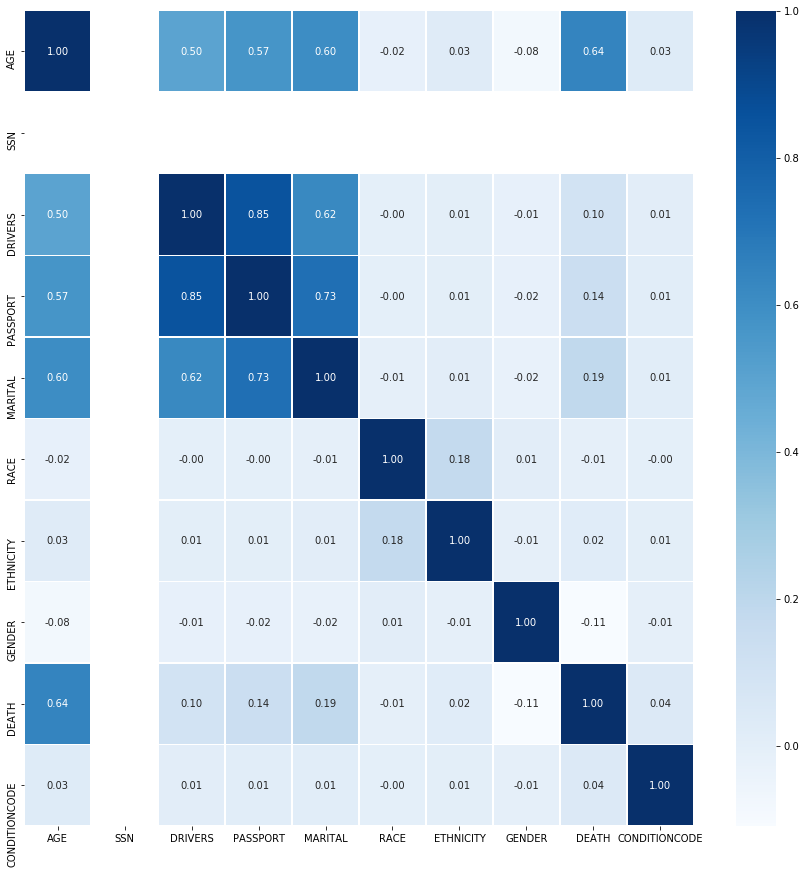

In [121]:
data = pd.DataFrame(newData, columns=newColumns)
plt.figure(figsize=(15,15))
sns.heatmap(data=data.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')